In [1]:
import numpy as np
import plotly.graph_objects as go
from sympy import Ellipse
from sympy import Point as Point2D
from sympy import cos, lambdify, sin, sqrt, symbols
from sympy.abc import t
from sympy.physics.vector import Point, ReferenceFrame

In [11]:
(eccentricity, semimajor_axis, true_anomaly) = symbols("e a ν", real=True)
(inclination, longitude_ascending_node, argument_of_periapsis) = symbols("i Ω ω")

In [3]:
E = ReferenceFrame("E")  # Equatorial Frame
O = ReferenceFrame("O")  # Orbital Frame
O.orient_body_fixed(
    E, [longitude_ascending_node, inclination, argument_of_periapsis], "313"
)

In [17]:
orbit = Ellipse(
    Point2D(-semimajor_axis * eccentricity, 0),
    hradius=semimajor_axis,
    eccentricity=eccentricity,
)
x, y = orbit.arbitrary_point(parameter=t)
ellipse_pos = x * O.x + y * O.y

ellipse_point = lambdify(
    (
        semimajor_axis,
        eccentricity,
        longitude_ascending_node,
        inclination,
        argument_of_periapsis,
        t,
    ),
    ellipse_pos.to_matrix(E).transpose().tolist()[0],
)

In [23]:
primary_body = Point("A")
center = primary_body.locatenew("C", -O.x * semimajor_axis * eccentricity)

# E refers to the eccentric anomaly
cos_E = (eccentricity + cos(true_anomaly)) / (1 + eccentricity * cos(true_anomaly))
sin_E = (sqrt(1 - eccentricity ** 2) * sin(true_anomaly)) / (
    1 + eccentricity * cos(true_anomaly)
)
radius = (semimajor_axis * (1 - eccentricity ** 2)) / (1 + eccentricity * cos(true_anomaly))

secondary_body = center.locatenew(
    "B", O.x * radius * cos_E + O.y * radius * sin_E
)

In [19]:
secondary_body_position = lambdify(
    (
        semimajor_axis,
        eccentricity,
        true_anomaly,
        longitude_ascending_node,
        inclination,
        argument_of_periapsis,
    ),
    secondary_body.pos_from(primary_body).to_matrix(E).transpose().tolist()[0],
)

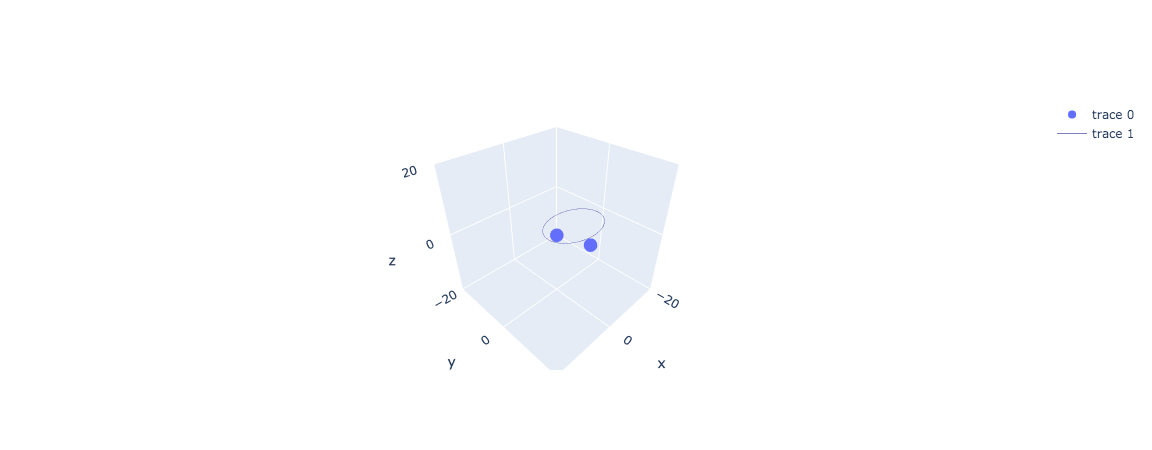

In [22]:
semimajor_axis_val = 10
eccentricity_val = 0.7
true_anomaly_val = 2
longitude_ascending_node_val = 0
inclination_val = 0
argument_of_periapsis_val = 0

primary = [0, 0, 0]
secondary = secondary_body_position(
    semimajor_axis_val,
    eccentricity_val,
    true_anomaly_val,
    longitude_ascending_node_val,
    inclination_val,
    argument_of_periapsis_val,
)
x, y, z = zip(primary, secondary)
trace_bodies = go.Scatter3d(x=x, y=y, z=z, mode="markers")

x_ellipse, y_ellipse, z_ellipse = np.transpose(
    [
        ellipse_point(
            semimajor_axis_val,
            eccentricity_val,
            longitude_ascending_node_val,
            inclination_val,
            argument_of_periapsis_val,
            t,
        )
        for t in np.linspace(0, 2 * np.pi, 500)
    ]
)
trace_orbit_ellipse = go.Scatter3d(
    x=x_ellipse,
    y=y_ellipse,
    z=z_ellipse,
    mode="lines",
    line=dict(color="darkblue", width=0.5),
)

fig = go.Figure(data=[trace_bodies, trace_orbit_ellipse])
fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=4, range=[-2 * semimajor_axis_val, 2 * semimajor_axis_val],),
        yaxis=dict(nticks=4, range=[-2 * semimajor_axis_val, 2 * semimajor_axis_val],),
        zaxis=dict(nticks=4, range=[-2 * semimajor_axis_val, 2 * semimajor_axis_val],),
    )
)
fig.show()